In [80]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib
import copy

In [81]:
fips_codes = pd.read_csv('Data/county_state_fips_codes.csv')
fips_codes['FIPS'] = fips_codes['FIPS'].astype(str).str.zfill(6)
fips_codes.tail()

,FIPS,County,State,State_Abbr,sumlev,region,division,state,county,crosswalk,region_name,division_name
3189,056037,Sweetwater County,Wisconsin,WY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3190,056039,Teton County,Wisconsin,WY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3191,056041,Uinta County,Wisconsin,WY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3192,056043,Washakie County,Wisconsin,WY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3193,056045,Weston County,Wisconsin,WY,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Flows

In [5]:
url = "https://www2.census.gov/programs-surveys/demo/tables/geographic-mobility/2019/county-to-county-migration-2015-2019/county-to-county-migration-flows/Net_Gross_US.txt"
urllib.request.urlretrieve(url, "Data/Net Gross US.txt")

('Data/Net Gross US.txt', <http.client.HTTPMessage at 0x7fb2242a7460>)

In [18]:
df = pd.read_fwf('Data/Net Gross US.txt',header = None,
                 names = ['id', 'state1', 'temp_county1', 'temp_County', 'state2', 'county2',
                          'Flow from Geography 2 to Geography 1', 'MOE1', 
                          'Counterflow from Geography 1 to Geography 2' , 'MOE2',
                          'Net Migration from Geography 2 to Geography 1', 'MOE3',
                          'Gross Migration between Geography 1 and Geography 2', 'MOE4'] )
# MOE - Margin of error based on 90% confidence interval.

df['county1'] = df['temp_county1'] + ' ' + df['temp_County']
df.drop(['temp_county1', 'temp_County'], axis=1, inplace=True)

df = df[['id', 'state1', 'county1', 'state2', 'county2',
         'Flow from Geography 2 to Geography 1', 'MOE1', 
         'Counterflow from Geography 1 to Geography 2' , 'MOE2',
         'Net Migration from Geography 2 to Geography 1', 'MOE3',
         'Gross Migration between Geography 1 and Geography 2', 'MOE4']]

not_Mainland = ['Alaska', 'Hawaii', 'Puerto Rico', 'Puerto' ]
df = df[~df['state1'].isin(not_Mainland)] 
df = df[~df['state2'].isin(not_Mainland)]
df = df[df['county1'].notna()]
df = df[df['county2'].notna()]
df
#df = df[df['EPS'].notna()]
#df = df[~df['date'].isin(a)]

,id,state1,county1,state2,county2,Flow from Geography 2 to Geography 1,MOE1,Counterflow from Geography 1 to Geography 2,MOE2,Net Migration from Geography 2 to Geography 1,MOE3,Gross Migration between Geography 1 and Geography 2,MOE4
0,001001001003,Alabama,Autauga County,Alabama,Baldwin County,25.0,26.0,448.0,461.0,-423.0,461.0,473.0,463.0
1,001001001005,Alabama,Autauga County,Alabama,Barbour County,4.0,8.0,0.0,22.0,4.0,8.0,4.0,8.0
2,001001001007,Alabama,Autauga County,Alabama,Bibb County,10.0,16.0,34.0,52.0,-24.0,54.0,44.0,54.0
3,001001001009,Alabama,Autauga County,Alabama,Blount County,3.0,6.0,0.0,28.0,3.0,6.0,3.0,6.0
4,001001001015,Alabama,Autauga County,Alabama,Calhoun County,2.0,4.0,42.0,46.0,-40.0,47.0,44.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
432070,056045056033,Wyoming,Weston ounty,Wyoming,Sheridan County,7.0,10.0,15.0,24.0,-8.0,27.0,22.0,26.0
432071,056045056035,Wyoming,Weston ounty,Wyoming,Sublette County,2.0,3.0,0.0,17.0,2.0,3.0,2.0,3.0
432072,056045056037,Wyoming,Weston ounty,Wyoming,Sweetwater County,12.0,9.0,0.0,25.0,12.0,9.0,12.0,9.0
432073,056045056041,Wyoming,Weston ounty,Wyoming,Uinta County,6.0,8.0,0.0,22.0,6.0,8.0,6.0,8.0


In [87]:
migrations = df[['id', 'Counterflow from Geography 1 to Geography 2']].copy()#, 'state1', 'county1', 'state2', 'county2']].copy()
migrations.rename(columns = {'Counterflow from Geography 1 to Geography 2':'flows'}, inplace = True)
migrations['county1_code'] = migrations['id'].str[0:6]
migrations['county2_code'] = migrations['id'].str[6:12]

migrations = migrations.merge(fips_codes, left_on='county1_code', right_on = 'FIPS', how = 'left')
migrations.drop_duplicates(subset=['id'], inplace =True)
migrations = migrations[['id', 'flows', 'county1_code', 'County', 'county2_code']]
migrations.rename(columns = {'County':'county1_name'}, inplace = True)

migrations = migrations.merge(fips_codes, left_on='county1_code', right_on = 'FIPS', how = 'left')
migrations.drop_duplicates(subset=['id'], inplace =True)
migrations = migrations[['id', 'flows', 'county1_code', 'county1_name', 'State', 'county2_code']]
migrations.rename(columns = {'State':'state1_name'}, inplace = True)

migrations = migrations.merge(fips_codes, left_on='county2_code', right_on = 'FIPS', how = 'left')
migrations.drop_duplicates(subset=['id'], inplace =True)
migrations = migrations[['id', 'flows', 'county1_code','county1_name', 'state1_name', 'county2_code', 'County']]
migrations.rename(columns = {'County':'county2_name'}, inplace = True)

migrations = migrations.merge(fips_codes, left_on='county2_code', right_on = 'FIPS', how = 'left')
migrations.drop_duplicates(subset=['id'], inplace =True)
migrations = migrations[['id', 'flows', 'county1_code','county1_name', 'state1_name', 'county2_code', 'county2_name', 'State']]
migrations.rename(columns = {'State':'state2_name'}, inplace = True)

migrations

,id,flows,county1_code,county1_name,state1_name,county2_code,county2_name,state2_name
0,001001001003,448.0,001001,Autauga County,Alabama,001003,Baldwin County,Alabama
1,001001001005,0.0,001001,Autauga County,Alabama,001005,Barbour County,Alabama
2,001001001007,34.0,001001,Autauga County,Alabama,001007,Bibb County,Alabama
3,001001001009,0.0,001001,Autauga County,Alabama,001009,Blount County,Alabama
4,001001001015,42.0,001001,Autauga County,Alabama,001015,Calhoun County,Alabama
...,...,...,...,...,...,...,...,...
428254,056045056033,15.0,056045,Weston County,Wyoming,056033,Sheridan County,Wyoming
428256,056045056035,0.0,056045,Weston County,Wyoming,056035,Sublette County,Wyoming
428258,056045056037,0.0,056045,Weston County,Wyoming,056037,Sweetwater County,Wyoming
428260,056045056041,0.0,056045,Weston County,Wyoming,056041,Uinta County,Wyoming


# Oi Emissiveness

In [90]:
emissiveness = migrations.groupby(['county1_code']).sum('flows')
migrations = migrations.merge(emissiveness, left_on='county1_code', right_on='county1_code', how='left')
migrations.drop_duplicates(subset=['id'], inplace =True)
migrations[['id', 'flows_x', 'county1_code','county1_name', 'state1_name', 'county2_code', 'county2_name', 'state2_name', 'flows_y']]
migrations.rename(columns = {'flows_x':'flows','flows_y':'emissiveness'}, inplace = True)
migrations

,id,flows,county1_code,county1_name,state1_name,county2_code,county2_name,state2_name,emissiveness
0,001001001003,448.0,001001,Autauga County,Alabama,001003,Baldwin County,Alabama,6098.0
1,001001001005,0.0,001001,Autauga County,Alabama,001005,Barbour County,Alabama,6098.0
2,001001001007,34.0,001001,Autauga County,Alabama,001007,Bibb County,Alabama,6098.0
3,001001001009,0.0,001001,Autauga County,Alabama,001009,Blount County,Alabama,6098.0
4,001001001015,42.0,001001,Autauga County,Alabama,001015,Calhoun County,Alabama,6098.0
...,...,...,...,...,...,...,...,...,...
421645,056045056033,15.0,056045,Weston County,Wyoming,056033,Sheridan County,Wyoming,413.0
421646,056045056035,0.0,056045,Weston County,Wyoming,056035,Sublette County,Wyoming,413.0
421647,056045056037,0.0,056045,Weston County,Wyoming,056037,Sweetwater County,Wyoming,413.0
421648,056045056041,0.0,056045,Weston County,Wyoming,056041,Uinta County,Wyoming,413.0


# Distance

In [3]:
distances = pd.read_csv("Data/county-to-county-distance.csv")
distances.head()

,county1,mi_to_county,county2
0,1001,22.462994,1021
1,1001,26.844687,1085
2,1001,29.517585,1051
3,1001,30.776371,1047
4,1001,34.493443,1101


In [4]:
distances['county1'] = distances['county1'].astype(str).str.zfill(6)
distances['county2'] = distances['county2'].astype(str).str.zfill(6)
distances['id'] = distances['county1'] + distances['county2']
distances.head()

,county1,mi_to_county,county2,id
0,001001,22.462994,001021,001001001021
1,001001,26.844687,001085,001001001085
2,001001,29.517585,001051,001001001051
3,001001,30.776371,001047,001001001047
4,001001,34.493443,001101,001001001101


In [91]:
migrations = migrations.merge(distances, left_on='id', right_on='id', how='left')
migrations.drop_duplicates(subset=['id'], inplace =True)
migrations = migrations[['id', 'flows', 'emissiveness', 'mi_to_county','county1_code','county1_name', 'state1_name', 'county2_code', 'county2_name', 'state2_name']]
migrations.rename(columns = {'mi_to_county':'distance'}, inplace = True)
migrations

,id,flows,emissiveness,distance,county1_code,county1_name,state1_name,county2_code,county2_name,state2_name
0,001001001003,448.0,6098.0,144.995720,001001,Autauga County,Alabama,001003,Baldwin County,Alabama
1,001001001005,0.0,6098.0,85.807128,001001,Autauga County,Alabama,001005,Barbour County,Alabama
2,001001001007,34.0,6098.0,43.403253,001001,Autauga County,Alabama,001007,Bibb County,Alabama
3,001001001009,0.0,6098.0,99.668005,001001,Autauga County,Alabama,001009,Blount County,Alabama
4,001001001015,42.0,6098.0,97.701681,001001,Autauga County,Alabama,001015,Calhoun County,Alabama
...,...,...,...,...,...,...,...,...,...,...
421645,056045056033,15.0,413.0,131.256801,056045,Weston County,Wyoming,056033,Sheridan County,Wyoming
421646,056045056035,0.0,413.0,278.871465,056045,Weston County,Wyoming,056035,Sublette County,Wyoming
421647,056045056037,0.0,413.0,265.511715,056045,Weston County,Wyoming,056037,Sweetwater County,Wyoming
421648,056045056041,0.0,413.0,352.291108,056045,Weston County,Wyoming,056041,Uinta County,Wyoming


In [98]:
mask = migrations['county2_code'].astype('str').str.len() == 3 # & (df['B'].str.len() == 10)
migrations = migrations.loc[~mask]
#= migrations.dropna()
#migrations.fillna(0,inplace=True)
"""
final_data = migrations[~migrations['state1'].isin(not_Mainland)] 
final_data = migrations[~migrations['state2'].isin(not_Mainland)]
migrations = migrations[migrations['state1'].notna()]
migrations = migrations[migrations['state2'].notna()]
"""
migrations

,id,flows,emissiveness,distance,county1_code,county1_name,state1_name,county2_code,county2_name,state2_name
0,001001001003,448.0,6098.0,144.995720,001001,Autauga County,Alabama,001003,Baldwin County,Alabama
1,001001001005,0.0,6098.0,85.807128,001001,Autauga County,Alabama,001005,Barbour County,Alabama
2,001001001007,34.0,6098.0,43.403253,001001,Autauga County,Alabama,001007,Bibb County,Alabama
3,001001001009,0.0,6098.0,99.668005,001001,Autauga County,Alabama,001009,Blount County,Alabama
4,001001001015,42.0,6098.0,97.701681,001001,Autauga County,Alabama,001015,Calhoun County,Alabama
...,...,...,...,...,...,...,...,...,...,...
421645,056045056033,15.0,413.0,131.256801,056045,Weston County,Wyoming,056033,Sheridan County,Wyoming
421646,056045056035,0.0,413.0,278.871465,056045,Weston County,Wyoming,056035,Sublette County,Wyoming
421647,056045056037,0.0,413.0,265.511715,056045,Weston County,Wyoming,056037,Sweetwater County,Wyoming
421648,056045056041,0.0,413.0,352.291108,056045,Weston County,Wyoming,056041,Uinta County,Wyoming


In [3]:
#counties = gpd.read_file("Data/cb_2018_us_county_20m/cb_2018_us_county_20m.shp")
#counties.columns

Index(['STATEFP', 'COUNTYFP', 'COUNTYNS', 'AFFGEOID', 'GEOID', 'NAME', 'LSAD',
       'ALAND', 'AWATER', 'geometry'],
      dtype='object')

In [104]:
counties = gpd.read_file("USA_Counties.geojson")
counties.columns

Index(['FID', 'OBJECTID', 'NAME', 'STATE_NAME', 'STATE_FIPS', 'CNTY_FIPS',
       'FIPS', 'POPULATION', 'POP_SQMI', 'POP2010', 'POP10_SQMI', 'WHITE',
       'BLACK', 'AMERI_ES', 'ASIAN', 'HAWN_PI', 'HISPANIC', 'OTHER',
       'MULT_RACE', 'MALES', 'FEMALES', 'AGE_UNDER5', 'AGE_5_9', 'AGE_10_14',
       'AGE_15_19', 'AGE_20_24', 'AGE_25_34', 'AGE_35_44', 'AGE_45_54',
       'AGE_55_64', 'AGE_65_74', 'AGE_75_84', 'AGE_85_UP', 'MED_AGE',
       'MED_AGE_M', 'MED_AGE_F', 'HOUSEHOLDS', 'AVE_HH_SZ', 'HSEHLD_1_M',
       'HSEHLD_1_F', 'MARHH_CHD', 'MARHH_NO_C', 'MHH_CHILD', 'FHH_CHILD',
       'FAMILIES', 'AVE_FAM_SZ', 'HSE_UNITS', 'VACANT', 'OWNER_OCC',
       'RENTER_OCC', 'NO_FARMS12', 'AVE_SIZE12', 'CROP_ACR12', 'AVE_SALE12',
       'SQMI', 'NO_FARMS17', 'AVE_SIZE17', 'CROP_ACR17', 'AVE_SALE17',
       'SHAPE_Length', 'SHAPE_Area', 'geometry'],
      dtype='object')

<AxesSubplot:>

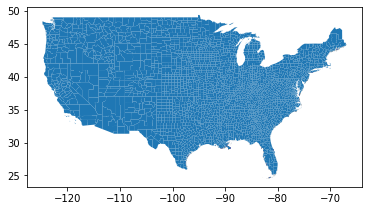

In [105]:
mainland1 = counties.loc[counties['STATE_FIPS'] != '02']#Alaska
mainland2 = mainland1.loc[mainland1['STATE_FIPS'] != '15']#Hawaii
mainland = mainland2.loc[mainland2['STATE_FIPS'] != '72']#Puerto Rico
mainland.plot()

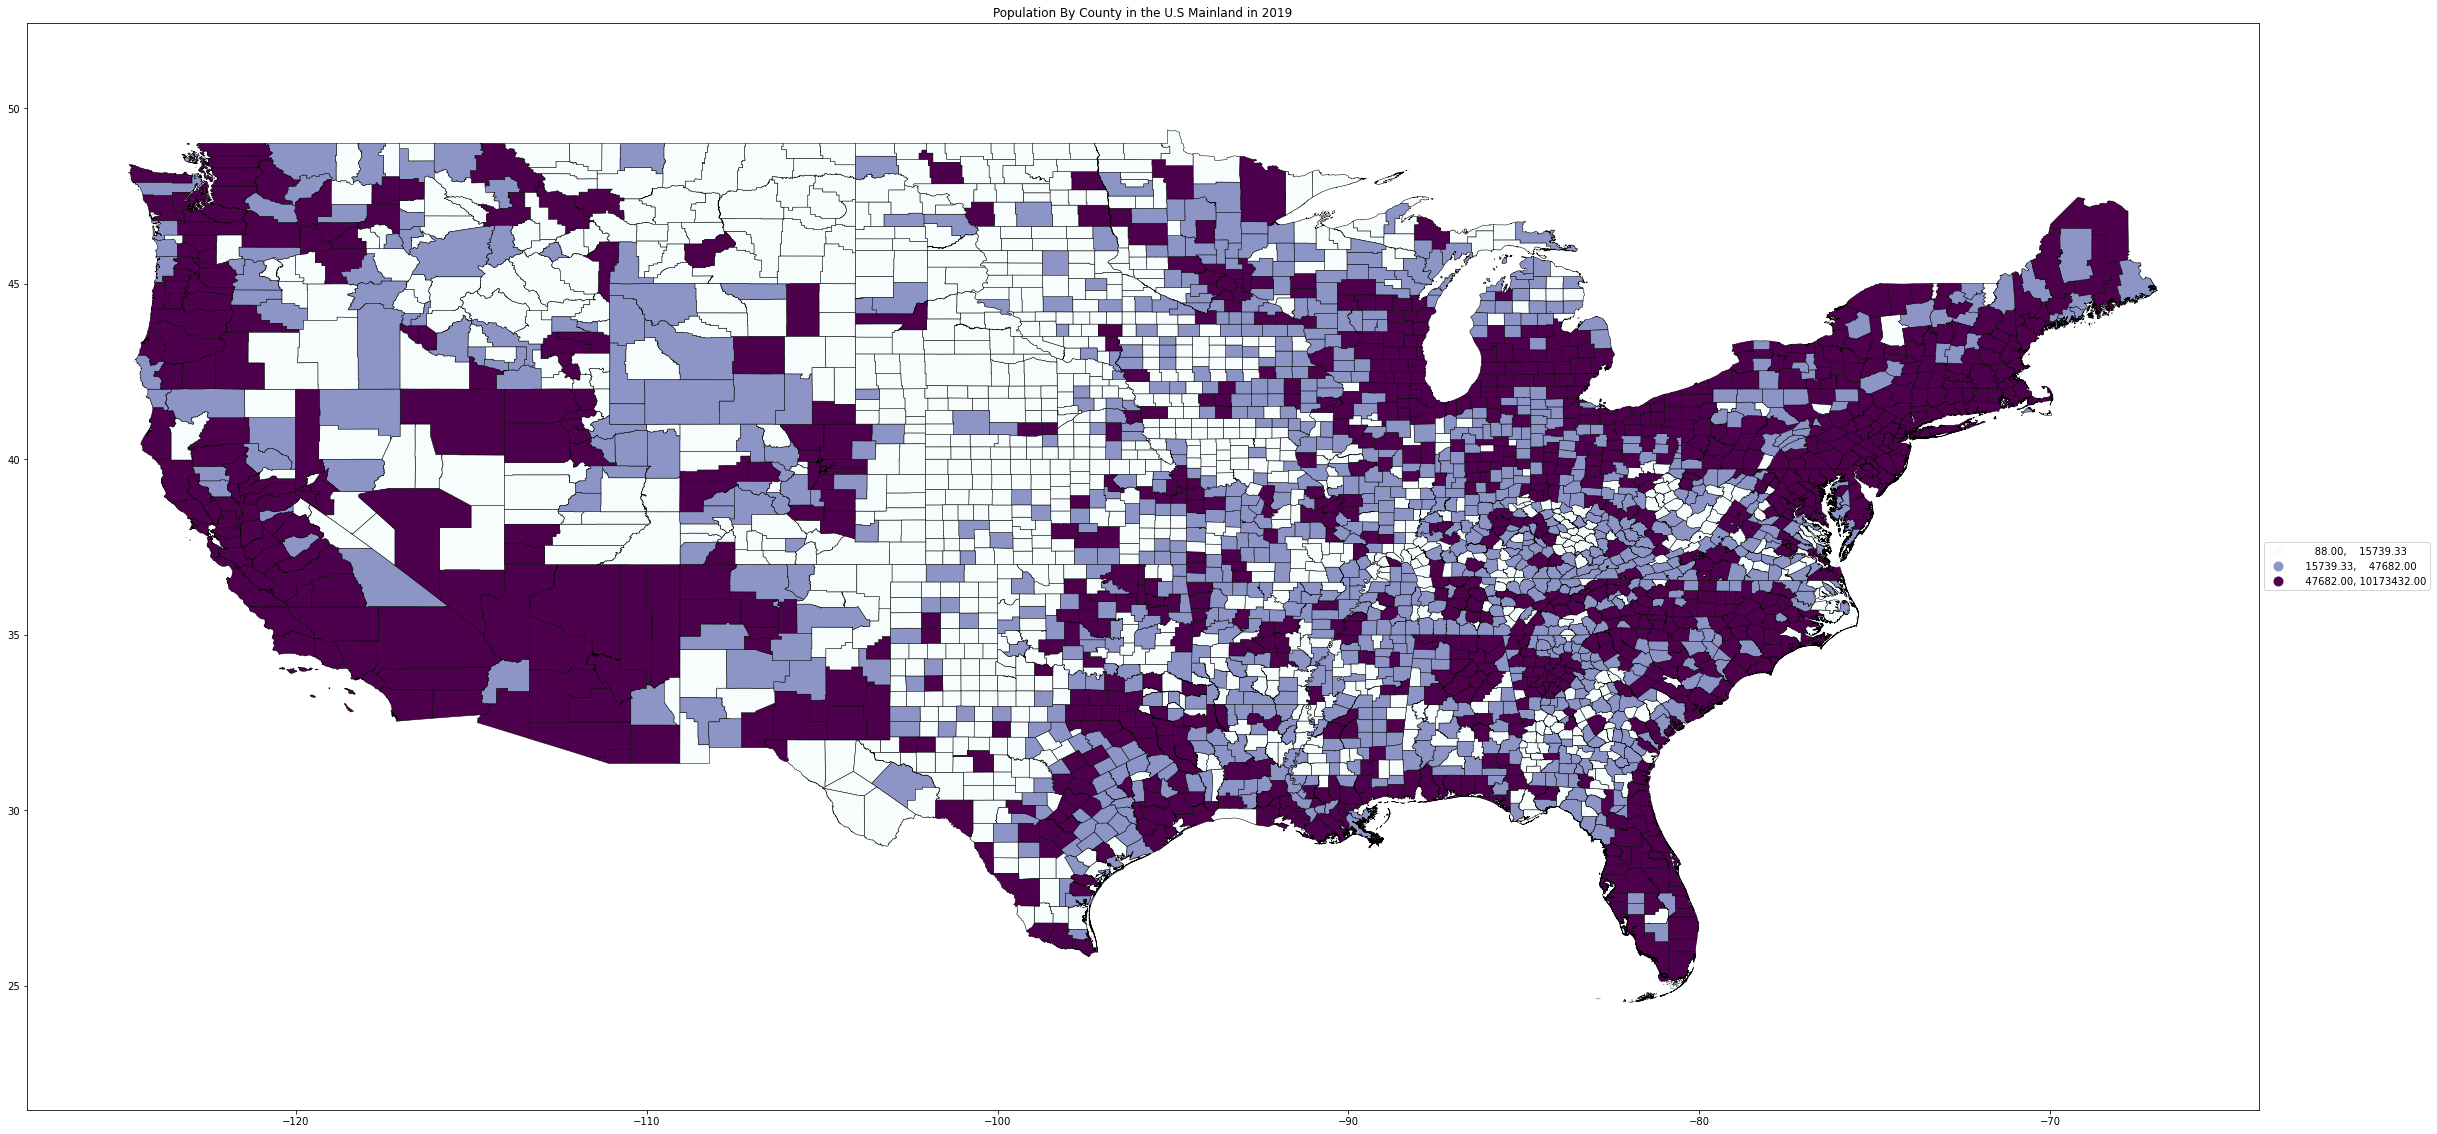

In [106]:
fig, ax = plt.subplots(1, 1, figsize=(40,20))
mainland.plot(ax=ax,
              column='POPULATION',
              scheme='quantiles', k=3,
              cmap='BuPu', linewidth = 0.5, edgecolor = "k",
              legend=True, legend_kwds={'loc': 'center left', 'bbox_to_anchor':(1,0.5)})
ax.set_title('Population By County in the U.S Mainland in 2019')
plt.axis('equal');
#plt.savefig('pop by county.jpg')

In [174]:
mainland['FIPS'] = mainland['FIPS'].astype(str).str.zfill(6)
#final_data['population'] = final_data.merge(mainland, left_on='county2_code', right_on='FIPS', how='left')['POPULATION']
final_data = migrations.merge(mainland, left_on='county2_code', right_on='FIPS', how='left')
final_data.drop_duplicates(subset=['id'], inplace =True)
final_data = final_data[['id', 'flows', 'emissiveness', 'POPULATION', 'distance', 'county1_code','county1_name', 'state1_name', 'county2_code', 'county2_name', 'state2_name']]
final_data.rename(columns = {'POPULATION':'population'}, inplace = True)
final_data


/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,id,flows,emissiveness,population,distance,county1_code,county1_name,state1_name,county2_code,county2_name,state2_name
0,001001001003,448.0,6098.0,227660,144.995720,001001,Autauga County,Alabama,001003,Baldwin County,Alabama
1,001001001005,0.0,6098.0,26326,85.807128,001001,Autauga County,Alabama,001005,Barbour County,Alabama
2,001001001007,34.0,6098.0,23066,43.403253,001001,Autauga County,Alabama,001007,Bibb County,Alabama
3,001001001009,0.0,6098.0,59970,99.668005,001001,Autauga County,Alabama,001009,Blount County,Alabama
4,001001001015,42.0,6098.0,116592,97.701681,001001,Autauga County,Alabama,001015,Calhoun County,Alabama
...,...,...,...,...,...,...,...,...,...,...,...
411597,056045056033,15.0,413.0,31595,131.256801,056045,Weston County,Wyoming,056033,Sheridan County,Wyoming
411598,056045056035,0.0,413.0,10726,278.871465,056045,Weston County,Wyoming,056035,Sublette County,Wyoming
411599,056045056037,0.0,413.0,44774,265.511715,056045,Weston County,Wyoming,056037,Sweetwater County,Wyoming
411600,056045056041,0.0,413.0,21555,352.291108,056045,Weston County,Wyoming,056041,Uinta County,Wyoming


In [175]:
final_data.dropna(inplace = True)
final_data

,id,flows,emissiveness,population,distance,county1_code,county1_name,state1_name,county2_code,county2_name,state2_name
0,001001001003,448.0,6098.0,227660,144.995720,001001,Autauga County,Alabama,001003,Baldwin County,Alabama
1,001001001005,0.0,6098.0,26326,85.807128,001001,Autauga County,Alabama,001005,Barbour County,Alabama
2,001001001007,34.0,6098.0,23066,43.403253,001001,Autauga County,Alabama,001007,Bibb County,Alabama
3,001001001009,0.0,6098.0,59970,99.668005,001001,Autauga County,Alabama,001009,Blount County,Alabama
4,001001001015,42.0,6098.0,116592,97.701681,001001,Autauga County,Alabama,001015,Calhoun County,Alabama
...,...,...,...,...,...,...,...,...,...,...,...
411597,056045056033,15.0,413.0,31595,131.256801,056045,Weston County,Wyoming,056033,Sheridan County,Wyoming
411598,056045056035,0.0,413.0,10726,278.871465,056045,Weston County,Wyoming,056035,Sublette County,Wyoming
411599,056045056037,0.0,413.0,44774,265.511715,056045,Weston County,Wyoming,056037,Sweetwater County,Wyoming
411600,056045056041,0.0,413.0,21555,352.291108,056045,Weston County,Wyoming,056041,Uinta County,Wyoming


#back up in case we need to calculate string lengths
is_NaN = migrations.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = migrations[row_has_NaN]

rows_with_NaN['county2_code'] = rows_with_NaN['county2_code'].astype('str')
mask = (rows_with_NaN['county2_code'].str.len() == 3) # & (df['B'].str.len() == 10)
rows_with_NaN = rows_with_NaN.loc[mask]
print(rows_with_NaN)

# Some Distances are not calculated

In [109]:
is_NaN = migrations.isnull()
row_has_NaN = is_NaN.any(axis=1)
rows_with_NaN = migrations[row_has_NaN]

In [110]:
rows_with_NaN

,id,flows,emissiveness,distance,county1_code,county1_name,state1_name,county2_code,county2_name,state2_name
20636,006001046102,0.0,91191.0,NaN,006001,Alameda County,California,046102,Oglala Lakota County,South Dakota
23300,006029046102,27.0,35012.0,NaN,006029,Kern County,California,046102,Oglala Lakota County,South Dakota
28500,006065046102,20.0,75523.0,NaN,006065,Riverside County,California,046102,Oglala Lakota County,South Dakota
31135,006073046102,0.0,133876.0,NaN,006073,San Diego County,California,046102,Oglala Lakota County,South Dakota
43192,008059046102,0.0,47590.0,NaN,008059,Jefferson County,Colorado,046102,Oglala Lakota County,South Dakota
...,...,...,...,...,...,...,...,...,...,...
329057,046129046102,1.0,492.0,NaN,046129,Walworth County,South Dakota,046102,Oglala Lakota County,South Dakota
329159,046135046102,0.0,1789.0,NaN,046135,Yankton County,South Dakota,046102,Oglala Lakota County,South Dakota
408710,055001046102,0.0,1192.0,NaN,055001,Adams County,Wisconsin,046102,Oglala Lakota County,South Dakota
420088,056015046102,7.0,1111.0,NaN,056015,Goshen County,Wyoming,046102,Oglala Lakota County,South Dakota


# Remove two flow because the emissiveness is 0

In [134]:
row_with_zeros = final_data[final_data['emissiveness'] == 0]
row_with_zeros

,id,flows,emissiveness,population,distance,county1_code,county1_name,state1_name,county2_code,county2_name,state2_name
350757,048261017163,0.0,0.0,264400,914.954454,048261,Kenedy County,Texas,017163,St. Clair County,Illinois
350758,048261048249,0.0,0.0,41710,65.844131,048261,Kenedy County,Texas,048249,Jim Wells County,Texas


# Remove rows with 0 flow

In [141]:
row_with_zeros_f = final_data[final_data['flows'] == 0]
row_with_zeros_f

,id,flows,emissiveness,population,distance,county1_code,county1_name,state1_name,county2_code,county2_name,state2_name
1,001001001005,0.0,6098.0,26326,85.807128,001001,Autauga County,Alabama,001005,Barbour County,Alabama
3,001001001009,0.0,6098.0,59970,99.668005,001001,Autauga County,Alabama,001009,Blount County,Alabama
11,001001001035,0.0,6098.0,12888,79.224318,001001,Autauga County,Alabama,001035,Conecuh County,Alabama
20,001001001077,0.0,6098.0,94715,173.516556,001001,Autauga County,Alabama,001077,Lauderdale County,Alabama
27,001001001093,0.0,6098.0,30744,131.710038,001001,Autauga County,Alabama,001093,Marion County,Alabama
...,...,...,...,...,...,...,...,...,...,...,...
411594,056045056023,0.0,413.0,19813,328.066406,056045,Weston County,Wyoming,056023,Lincoln County,Wyoming
411596,056045056031,0.0,413.0,8968,120.190323,056045,Weston County,Wyoming,056031,Platte County,Wyoming
411598,056045056035,0.0,413.0,10726,278.871465,056045,Weston County,Wyoming,056035,Sublette County,Wyoming
411599,056045056037,0.0,413.0,44774,265.511715,056045,Weston County,Wyoming,056037,Sweetwater County,Wyoming


In [176]:
final_data.drop(final_data.index[final_data['emissiveness'] == 0], inplace = True)
#final_data.drop(final_data.index[final_data['flows'] == 0], inplace = True)
#final_data

# having 0 flow